In [1]:
from trading import Asset
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as xp

In [5]:
asset = Asset(
    "LTC",
    start = datetime(2023,3,30),
    end = datetime.now(),
    frequency="1min",
    broker = "binance",
    fiat = "USDT",
    source="ext_api"
)

In [6]:
asset.df.shape

,open,high,low,close,volume,quotevolume
date,,,,,,
2023-03-29 06:00:00,90.68,90.74,90.68,90.68,40.269,3652.54817
2023-03-29 06:01:00,90.68,90.68,90.63,90.63,255.939,23201.25560
2023-03-29 06:02:00,90.63,90.63,90.40,90.40,1324.886,119940.43120
2023-03-29 06:03:00,90.40,90.43,90.34,90.37,1277.065,115422.91527
2023-03-29 06:04:00,90.38,90.43,90.34,90.42,623.007,56313.37271
...,...,...,...,...,...,...
2023-05-01 05:39:00,87.44,87.46,87.43,87.43,15.201,1329.29119
2023-05-01 05:40:00,87.43,87.43,87.38,87.41,201.493,17611.77774
2023-05-01 05:41:00,87.41,87.42,87.35,87.35,279.386,24409.88304


In [7]:
from sklearn.linear_model import LinearRegression

In [40]:
asset.df["trend"] = asset.ema(60)
asset.df["trend_res"] = asset.df["close"] - asset.df["trend"]
asset.df["season"] = asset.sma( 30, target = "trend_res" )
asset.df["season_res"] = asset.df["trend_res"] - asset.df["season"]
asset.df["rsi"] = asset.rsi_smoth( 10, 10 )

<AxesSubplot: xlabel='date'>

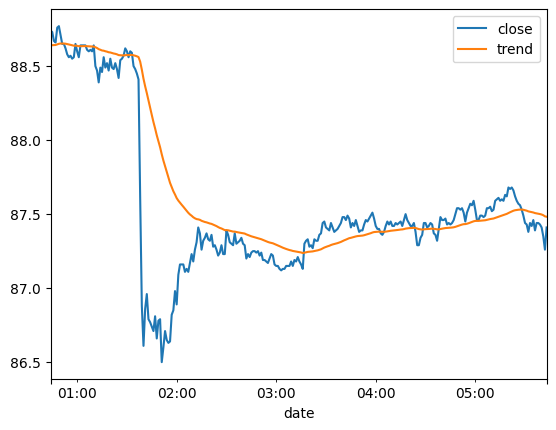

In [12]:
asset.df[["close", "trend"]].iloc[-300:].plot()

In [24]:
from sklearn.model_selection import train_test_split

X = np.array(asset.df["trend"].iloc[:-1]).reshape(-1, 1)
y = asset.df["trend"].shift(-1).dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree=3
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [27]:
y_pred = polyreg.predict(X_test)

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
mean_squared_error( np.array(y_test), y_pred )

0.00011627508402182463

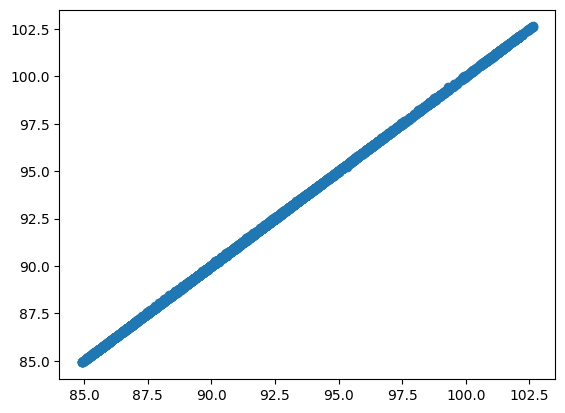

In [32]:
plt.scatter(np.array(y_test), y_pred)


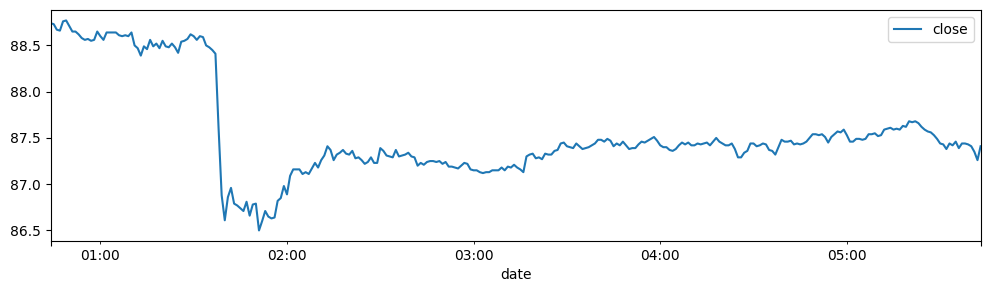

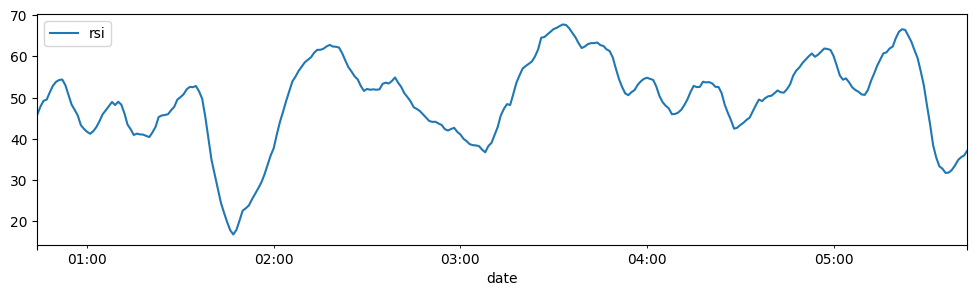

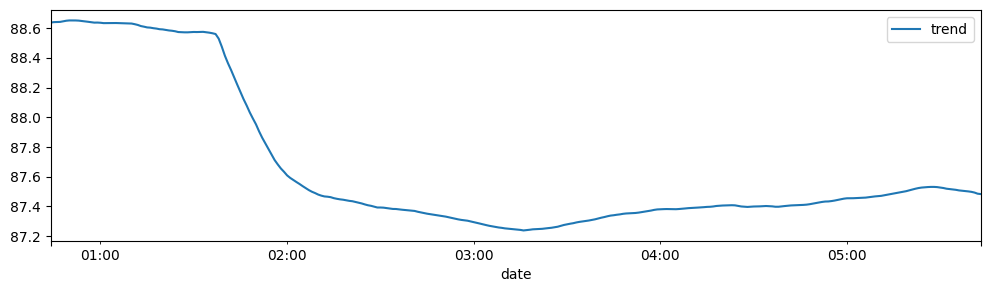

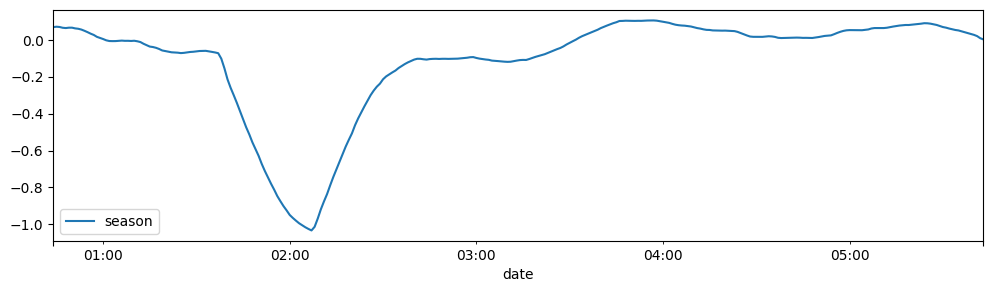

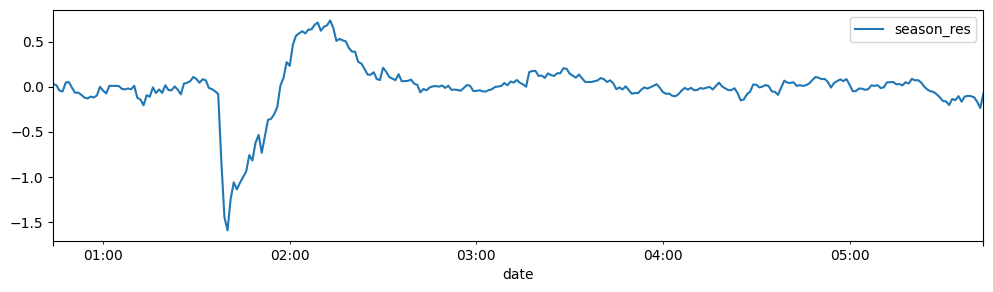

In [41]:
for i in ["close", "rsi", "trend", "season", "season_res" ]:
    asset.df[[i]].iloc[-300:].plot(figsize = (12,3))
    plt.show()

In [ ]:
seasonal = asset.df[["season"]].dropna()

In [ ]:
# sampling rate
sr = len(seasonal)
# sampling interval
ts = 1/sr
t = np.arange(0,1,ts)

r = round(seasonal["season"].std(), ndigits=2)

reg = []
for i in range(4, 100, 2):
    y = np.sin(np.pi*i*t) * r

    seasonal["sin"] = y

    error  = np.linalg.norm( seasonal["season"] - seasonal["sin"] )

    reg.append([ i, error ])


reg = pd.DataFrame(reg, columns = ["freq", "error"])
xp.scatter( reg, x = "freq", y = "error" )


In [ ]:
reg[ reg[ "error" ] == reg["error"].min() ]["freq"].iloc[0]

In [ ]:
i = reg[ reg[ "error" ] == reg["error"].min() ]["freq"].iloc[0]
y = np.sin(np.pi*i*t)*r

seasonal["sin"] = y
seasonal.plot(figsize = (12,4))

In [ ]:
zeros = np.zeros(len(asset.df) - len(y))
asset.df[ "sin" ] = zeros.tolist() + y.tolist()

In [ ]:
asset.df["trend sin"] = asset.df["trend"] + asset.df["sin"]

In [ ]:
xp.line(asset.df[["sin"]])

In [ ]:
asset.df["sin diff"] = asset.df["sin"].diff()

In [ ]:
asset.df["buy"] = asset.df["sin"] == asset.df["sin"].min()

In [ ]:
def sell_column(asset, target ):
    asset.df["sell"] = False
    true_values = asset.df[ asset.df["buy"] == True ].index.tolist()
    close = asset.df["close"]

    if len(true_values) == 0:
        return asset

    last_value_index = true_values[-1]

    for i in true_values:
        close_price = close[i] # bought price
        close_aux = close[ i: ]
        close_aux = ( close_aux / close_price ) - 1
        pct_index = close_aux[ close_aux >= target ]

        if len(pct_index) == 0:
            # Esta entrada nos indica que como no hay mejor, entonces el retorno de la estrategia 
            # estara ligada al ultrimo precio de nuestro tabal
            # Sera el ultimo precio de la tabla lo que sera considerado como la orden de cierre.
            asset.df.loc[ -1, "sell" ] = True
            # raise Exception( "Testing did not prove a better return." )
            break
        
        pct_index = pct_index.index[0]

        try:
            asset.df.loc[ pct_index, "sell" ] = True
        except Exception as e:
            raise Exception( f"{e}. Got {type(pct_index)} from {pct_index}." )
    
    return asset

In [ ]:
asset = sell_column(asset, target = 0.0015)

In [ ]:
from trading.testers.rules_testing import rule_validation


In [ ]:
df = rule_validation(asset)

In [ ]:
df